In [1]:
%run 0_Regressions_Common.ipynb


In [2]:
feature_sets = pos_feature_sets
label = positivity_label
text_label = "test positivity rate"
text_label_cap = "Positivity Rate"
label_daily = "positivity_rate"

In [3]:
file_suffix='mar9'

with open('../OtherData/CombinedDFAdjPopulationExcessMobility_%s.pkl' % (file_suffix), 'rb') as handle:
    df = pickle.load(handle)

In [4]:
with open('../OtherData/0_regions_to_skip.pkl', 'rb') as handle:
    regions_to_skip = pickle.load(handle)

with open('../OtherData/0_test_8_regions_mar9.pkl', 'rb') as handle:
    val_regions = pickle.load(handle)
     
regions = list(set([x for x in val_regions if x not in regions_to_skip]))  
print("Number of test regions: %d" % (len(regions)))

Number of test regions: 7


In [5]:
change_font_size(18)

# Make Predictions

Run validation set feature selection with parameters representing exponentially weighted decay weekly and daily. Only one value should be >0 to represent the decay multiplier. The other value should be 0.

In [6]:
def run_exp_decay_experiments(exp_decay_weekly, exp_decay_daily):

    fs_to_region_to_dynamic_preds = dict()
    fs_to_region_to_osa_preds = dict()
    fs_to_region_to_osa_preds_train = dict()
    fs_to_region_to_osa_preds_dec = dict()

    fs_to_region_to_dynamic_mses = dict()
    fs_to_region_to_dynamic_mas = dict()
    fs_to_region_to_dynamic_mas_new = dict()
    fs_to_region_to_osa_mses = dict()
    fs_to_region_to_osa_mas = dict()
    fs_to_region_to_osa_mas_new = dict()
    fs_to_region_to_osa_mses_dec = dict()
    fs_to_region_to_osa_mas_dec = dict()
    fs_to_region_to_osa_mas_dec_new = dict()

    fs_to_region_to_dynamic_CM = dict()
    fs_to_region_to_osa_CM = dict()
    fs_to_region_to_osa_CM_train = dict()
    fs_to_region_to_osa_CM_dec = dict()
    fs_to_region_to_osa_CM_new = dict()
    fs_to_region_to_osa_CM_train_new = dict()
    fs_to_region_to_osa_CM_dec_new = dict()

    best_mse_fs_mse = 9999
    best_mse_fs_ma = 9999
    best_mse_fs_key = -1
    best_mse_fs_label = "null"

    best_ma_fs_mse = -1
    best_ma_fs_ma = -1
    best_ma_fs_key = -1
    best_ma_fs_label = "null"


    results_df = pd.DataFrame(columns=['Weekly Decay', 'Daily Decay', 'Key', 'Feature Set', 'MSE Nov',
                                       'MA Nov', 'MA (Tier) Nov', 'MSE Dec', 'MA Dec', 'MA (Tier) Dec'])

    for key in feature_sets.keys():
        features = feature_sets[key]

        fs_to_region_to_dynamic_preds[key] = dict()
        fs_to_region_to_osa_preds[key] = dict()
        fs_to_region_to_osa_preds_train[key] = dict()
        fs_to_region_to_osa_preds_dec[key] = dict()

        fs_to_region_to_dynamic_mses[key] = dict()
        fs_to_region_to_dynamic_mas[key] = dict()
        fs_to_region_to_dynamic_mas_new[key] = dict()
        fs_to_region_to_osa_mses[key] = dict()
        fs_to_region_to_osa_mas[key] = dict()
        fs_to_region_to_osa_mas_new[key] = dict()
        fs_to_region_to_osa_mses_dec[key] = dict()
        fs_to_region_to_osa_mas_dec[key] = dict()
        fs_to_region_to_osa_mas_dec_new[key] = dict()

        fs_to_region_to_dynamic_CM[key] = dict()
        fs_to_region_to_osa_CM[key] = dict()
        fs_to_region_to_osa_CM_train[key] = dict()
        fs_to_region_to_osa_CM_dec[key] = dict()
        fs_to_region_to_osa_CM_new[key] = dict()
        fs_to_region_to_osa_CM_train_new[key] = dict()
        fs_to_region_to_osa_CM_dec_new[key] = dict()

        for region in regions:
            region_start = time.time()
            od_df=df.where(df["Region"]==region).dropna()
            train = od_df.where(od_df["Date"] >= train_begin).where(od_df["Date"] <= '2020-10-24').dropna()
            test = od_df.where(od_df["Date"] >= '2020-11-01').where(od_df["Date"] <= '2020-12-07').dropna()
            train_dec = od_df.where(od_df["Date"] >= train_begin).where(od_df["Date"] <= '2020-11-23').dropna()
            dec = od_df.where(od_df["Date"] >= '2020-12-01').where(od_df["Date"] <= '2021-01-07').dropna()

            train_new = train.sort_index().dropna()
            train_dec_new = train_dec.sort_index().dropna()
            test_new = test.sort_index().dropna()
            dec_new = dec.sort_index().dropna()
            features_min_max = preprocessing.MinMaxScaler()
            X_train = features_min_max.fit_transform(train_new[features])
            y_train = train_new[label]
            y_train_eval = train_new[label]
            X_test = features_min_max.transform(test_new[features])
            y_test = test_new[label]
            y_test_eval = test_new[label]
            
            X_train_dec = features_min_max.fit_transform(train_dec_new[features])
            y_train_dec = train_dec_new[label]
            y_train_dec_eval = train_dec_new[label]
            X_dec = features_min_max.transform(dec_new[features])
            y_dec = dec_new[label]
            y_dec_eval = dec_new[label]

            dynamic_preds = make_dynamic_preds(X_train, y_train, X_test, y_test,
                                               exp_decay_weekly=exp_decay_weekly, exp_decay_daily=exp_decay_daily)
            osa_preds = make_osa_preds(X_train, y_train, X_test, y_test,
                                       exp_decay_weekly=exp_decay_weekly, exp_decay_daily=exp_decay_daily)
            osa_preds_dec = make_osa_preds(X_train_dec, y_train_dec, X_dec, y_dec,
                                       exp_decay_weekly=exp_decay_weekly, exp_decay_daily=exp_decay_daily)


            fs_to_region_to_dynamic_preds[key][region] = dynamic_preds
            fs_to_region_to_osa_preds[key][region] = osa_preds
            fs_to_region_to_osa_preds_dec[key][region] = osa_preds_dec

            dynamic_mse = mean_squared_error(dynamic_preds[:-7], y_test_eval[:-7])
            dynamic_ma = magnitude_accuracy_pr(dynamic_preds, y_test_eval)
            dynamic_ma_new = magnitude_accuracy_prt(dynamic_preds, y_test_eval)
            osa_mse = mean_squared_error(osa_preds[:-7], y_test_eval[:-7]) 
            osa_ma = magnitude_accuracy_pr(osa_preds, y_test_eval) 
            osa_ma_new = magnitude_accuracy_prt(osa_preds, y_test_eval) 
            osa_mse_dec = mean_squared_error(osa_preds_dec[:-7], y_dec_eval[:-7]) 
            osa_ma_dec = magnitude_accuracy_pr(osa_preds_dec, y_dec_eval) 
            osa_ma_dec_new = magnitude_accuracy_prt(osa_preds_dec, y_dec_eval) 

            fs_to_region_to_dynamic_mses[key][region] = dynamic_mse
            fs_to_region_to_dynamic_mas[key][region] = dynamic_ma
            fs_to_region_to_osa_mses[key][region] = osa_mse
            fs_to_region_to_osa_mas[key][region] = osa_ma
            fs_to_region_to_osa_mas_new[key][region] = osa_ma_new
            fs_to_region_to_osa_mses_dec[key][region] = osa_mse_dec
            fs_to_region_to_osa_mas_dec[key][region] = osa_ma_dec
            fs_to_region_to_osa_mas_dec_new[key][region] = osa_ma_dec_new

            fs_to_region_to_dynamic_CM[key][region] = confusion_matrix_pr(dynamic_preds, y_test)
            fs_to_region_to_osa_CM[key][region] = confusion_matrix_pr(osa_preds, y_test)
            fs_to_region_to_osa_CM_new[key][region] = confusion_matrix_prt(osa_preds, y_test)
            fs_to_region_to_osa_CM_dec[key][region] = confusion_matrix_pr(osa_preds_dec, y_dec_eval)
            fs_to_region_to_osa_CM_dec_new[key][region] = confusion_matrix_prt(osa_preds_dec, y_dec_eval)

            region_end = time.time()
            
        this_fs_dynamic_average_mse = np.mean(list(fs_to_region_to_dynamic_mses[key].values()))
        this_fs_dynamic_average_ma = np.mean(list(fs_to_region_to_dynamic_mas[key].values()))
        this_fs_osa_average_mse = np.mean(list(fs_to_region_to_osa_mses[key].values()))
        this_fs_osa_average_ma = np.mean(list(fs_to_region_to_osa_mas[key].values()))
        this_fs_osa_average_ma_new = np.mean(list(fs_to_region_to_osa_mas_new[key].values()))
        this_fs_osa_average_mse_dec = np.mean(list(fs_to_region_to_osa_mses_dec[key].values()))
        this_fs_osa_average_ma_dec = np.mean(list(fs_to_region_to_osa_mas_dec[key].values()))
        this_fs_osa_average_ma_dec_new = np.mean(list(fs_to_region_to_osa_mas_dec_new[key].values()))

        if this_fs_dynamic_average_mse < this_fs_osa_average_mse:
            best_mse_model_mse = this_fs_dynamic_average_mse
            best_mse_model_ma = this_fs_dynamic_average_ma
            best_mse_model_ma_new = -1
            best_mse_model_label = "dynamic"
            best_mse_model_mse_dec = -1
            best_mse_model_ma_dec = -1
            best_mse_model_ma_dec_new = -1
        else:
            best_mse_model_mse = this_fs_osa_average_mse
            best_mse_model_ma = this_fs_osa_average_ma
            best_mse_model_ma_new = this_fs_osa_average_ma_new
            best_mse_model_label = "osa"
            best_mse_model_mse_dec = this_fs_osa_average_mse_dec
            best_mse_model_ma_dec = this_fs_osa_average_ma_dec
            best_mse_model_ma_dec_new = this_fs_osa_average_ma_dec_new

        if best_mse_model_mse < best_mse_fs_mse:
            best_mse_fs_mse = best_mse_model_mse
            best_mse_fs_ma = best_mse_model_ma
            best_mse_fs_key = key
            best_mse_fs_label = best_mse_model_label
    
        results_df = results_df.append({'Weekly Decay': exp_decay_weekly,
                                        'Daily Decay': exp_decay_daily,
                                        'Key': key,
                                        'Feature Set': feature_sets[key],
                                        'MSE Nov': best_mse_model_mse,
                                        'MA Nov': best_mse_model_ma,
                                        'MA (Tier) Nov': best_mse_model_ma_new,
                                        'MSE Dec': best_mse_model_mse_dec,
                                        'MA Dec': best_mse_model_ma_dec,
                                       'MA (Tier) Dec': best_mse_model_ma_dec_new}, ignore_index=True)
    
    return results_df, fs_to_region_to_dynamic_preds, fs_to_region_to_osa_preds, fs_to_region_to_osa_preds_dec

In [7]:
results_df_list = list()
dynamic_preds_list = list()
osa_preds_list = list()
dec_osa_preds_list = list()

decays = [0.5**0.5]

for weekly_decay in decays:
    this_r_df, this_dynamic_preds, this_osa_preds, this_dec_preds = run_exp_decay_experiments(weekly_decay, 0)
    results_df_list.append(this_r_df)
    dynamic_preds_list.append(this_dynamic_preds)
    osa_preds_list.append(this_osa_preds)
    dec_osa_preds_list.append(this_dec_preds)
    
for daily_decay in decays:
    this_r_df, this_dynamic_preds, this_osa_preds, this_dec_preds = run_exp_decay_experiments(0, daily_decay)
    results_df_list.append(this_r_df)
    dynamic_preds_list.append(this_dynamic_preds)
    osa_preds_list.append(this_osa_preds)
    dec_osa_preds_list.append(this_dec_preds)

In [8]:
all_results = pd.concat(results_df_list)

In [9]:
all_results.sort_values(by=['MSE Nov'], ascending=True).head(15)

,Weekly Decay,Daily Decay,Key,Feature Set,MSE Nov,MA Nov,MA (Tier) Nov,MSE Dec,MA Dec,MA (Tier) Dec
31,0,0.707107,32,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000020,0.866667,0.942857,0.000200,0.612903,0.617512
11,0,0.707107,12,[Positivity_Rate_7_1dayago],0.000020,0.866667,0.942857,0.000094,0.709677,0.732719
43,0,0.707107,44,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000021,0.866667,0.966667,0.000241,0.548387,0.612903
7,0,0.707107,8,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000023,0.885714,0.938095,0.000116,0.672811,0.709677
6,0,0.707107,7,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000024,0.847619,0.942857,0.000208,0.543779,0.594470
30,0,0.707107,31,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000025,0.861905,0.942857,0.000220,0.599078,0.576037
15,0,0.707107,16,"[Positivity_Rate_7_1dayago, Diff Internal_Move...",0.000025,0.852381,0.938095,0.000154,0.599078,0.645161
2,0,0.707107,3,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000025,0.861905,0.957143,0.000235,0.571429,0.622120
16,0,0.707107,17,"[Positivity_Rate_7_1dayago, Excess Internal_Mo...",0.000025,0.904762,0.942857,0.000160,0.626728,0.640553
9,0,0.707107,10,"[Positivity_Rate_7_1dayago, Diff Pressure_7_Ad...",0.000026,0.852381,0.938095,0.000158,0.663594,0.677419


In [10]:
results_to_consider = all_results.where(all_results["MSE Dec"] >=0).dropna()
results_to_consider["Eval MSE"] = (results_to_consider["MSE Nov"] * 30 + results_to_consider["MSE Dec"] * 31) / (61)

results_to_consider["Eval MA"] = (results_to_consider["MA Nov"] * 30 + results_to_consider["MA Dec"] * 31) / (61)
results_to_consider["Eval MA (Tier)"] = (results_to_consider["MA (Tier) Nov"] * 30 + results_to_consider["MA (Tier) Dec"] * 31) / (61)

results_to_consider.sort_values(by=['Eval MSE'], ascending=True).head(15)

,Weekly Decay,Daily Decay,Key,Feature Set,MSE Nov,MA Nov,MA (Tier) Nov,MSE Dec,MA Dec,MA (Tier) Dec,Eval MSE,Eval MA,Eval MA (Tier)
28,0.707107,0,29,"[Positivity_Rate_7_1dayago, Excess Pressure_7_...",0.000037,0.833333,0.890476,0.000058,0.811060,0.709677,0.000048,0.822014,0.798595
25,0.707107,0,26,"[Positivity_Rate_7_1dayago, Excess Internal_Mo...",0.000030,0.847619,0.909524,0.000067,0.797235,0.755760,0.000049,0.822014,0.831382
41,0.707107,0,42,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000048,0.771429,0.866667,0.000052,0.811060,0.737327,0.000050,0.791569,0.800937
38,0.707107,0,39,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000048,0.780952,0.900000,0.000060,0.797235,0.778802,0.000054,0.789227,0.838407
11,0,0.707107,12,[Positivity_Rate_7_1dayago],0.000020,0.866667,0.942857,0.000094,0.709677,0.732719,0.000058,0.786885,0.836066
18,0,0.707107,19,"[Positivity_Rate_7_1dayago, Excess Internal_Mo...",0.000054,0.838095,0.914286,0.000069,0.751152,0.751152,0.000062,0.793911,0.831382
31,0.707107,0,32,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000060,0.790476,0.919048,0.000064,0.741935,0.723502,0.000062,0.765808,0.819672
16,0.707107,0,17,"[Positivity_Rate_7_1dayago, Excess Internal_Mo...",0.000049,0.871429,0.942857,0.000078,0.691244,0.677419,0.000064,0.779859,0.807963
20,0.707107,0,21,"[Positivity_Rate_7_1dayago, Diff Pressure_7_Ad...",0.000077,0.666667,0.761905,0.000052,0.751152,0.718894,0.000064,0.709602,0.740047
53,0.707107,0,54,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000076,0.719048,0.833333,0.000054,0.806452,0.755760,0.000065,0.763466,0.793911


In [12]:

results_to_consider.sort_values(by=['Eval MA (Tier)'], ascending=False).head(15)

,Weekly Decay,Daily Decay,Key,Feature Set,MSE Nov,MA Nov,MA (Tier) Nov,MSE Dec,MA Dec,MA (Tier) Dec,Eval MSE,Eval MA,Eval MA (Tier)
38,0.707107,0,39,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000048,0.780952,0.900000,0.000060,0.797235,0.778802,0.000054,0.789227,0.838407
11,0,0.707107,12,[Positivity_Rate_7_1dayago],0.000020,0.866667,0.942857,0.000094,0.709677,0.732719,0.000058,0.786885,0.836066
25,0.707107,0,26,"[Positivity_Rate_7_1dayago, Excess Internal_Mo...",0.000030,0.847619,0.909524,0.000067,0.797235,0.755760,0.000049,0.822014,0.831382
18,0,0.707107,19,"[Positivity_Rate_7_1dayago, Excess Internal_Mo...",0.000054,0.838095,0.914286,0.000069,0.751152,0.751152,0.000062,0.793911,0.831382
7,0,0.707107,8,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000023,0.885714,0.938095,0.000116,0.672811,0.709677,0.000070,0.777518,0.822014
31,0.707107,0,32,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000060,0.790476,0.919048,0.000064,0.741935,0.723502,0.000062,0.765808,0.819672
6,0.707107,0,7,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000064,0.780952,0.904762,0.000069,0.764977,0.728111,0.000066,0.772834,0.814988
8,0,0.707107,9,"[Positivity_Rate_7_1dayago, Pressure_7_Adj100k...",0.000040,0.819048,0.942857,0.000579,0.677419,0.691244,0.000314,0.747073,0.814988
16,0.707107,0,17,"[Positivity_Rate_7_1dayago, Excess Internal_Mo...",0.000049,0.871429,0.942857,0.000078,0.691244,0.677419,0.000064,0.779859,0.807963
9,0,0.707107,10,"[Positivity_Rate_7_1dayago, Diff Pressure_7_Ad...",0.000026,0.852381,0.938095,0.000158,0.663594,0.677419,0.000093,0.756440,0.805621


In [13]:

    
with open('../OtherData/RegionColor.pkl', 'rb') as handle:
    colors = pickle.load(handle)
with open('../OtherData/RegionDarkColor.pkl', 'rb') as handle:
    dark_colors = pickle.load(handle)

In [65]:
df["rolling_std"] = df.groupby('Region')[label].transform(lambda x: x.rolling(14, 1).std())
df["rolling_mean"] = df.groupby('Region')[label].transform(lambda x: x.rolling(14, 1).mean())
df["95ci_lower"] = df[label] - 1.96*df["rolling_std"]
df["95ci_upper"] = df[label] + 1.96*df["rolling_std"]


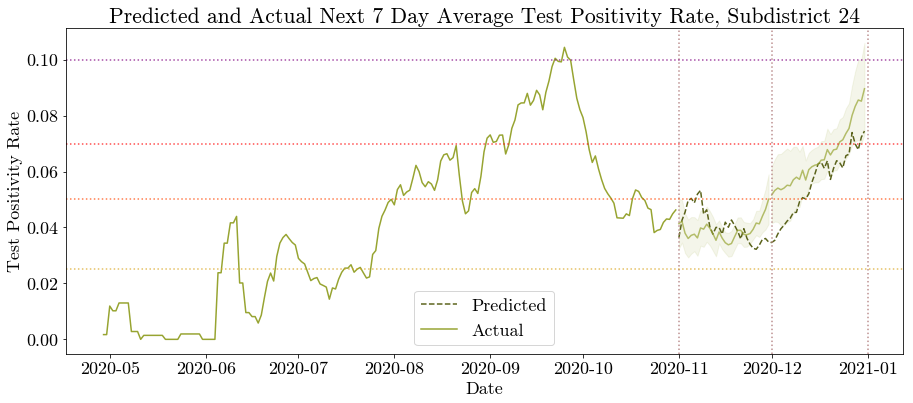

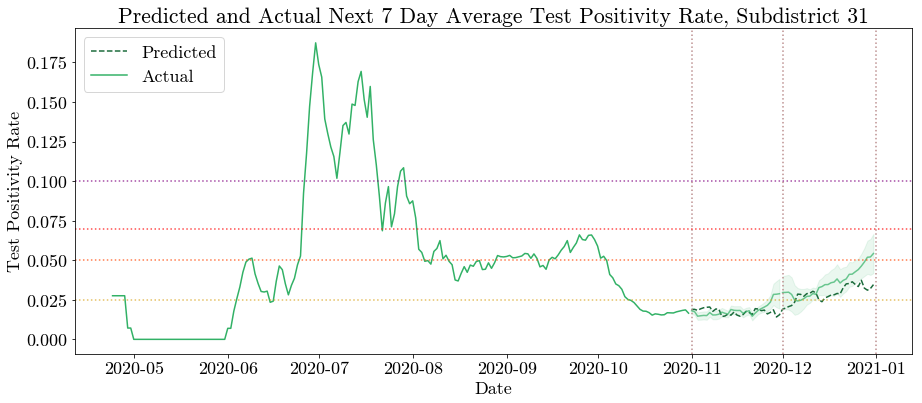

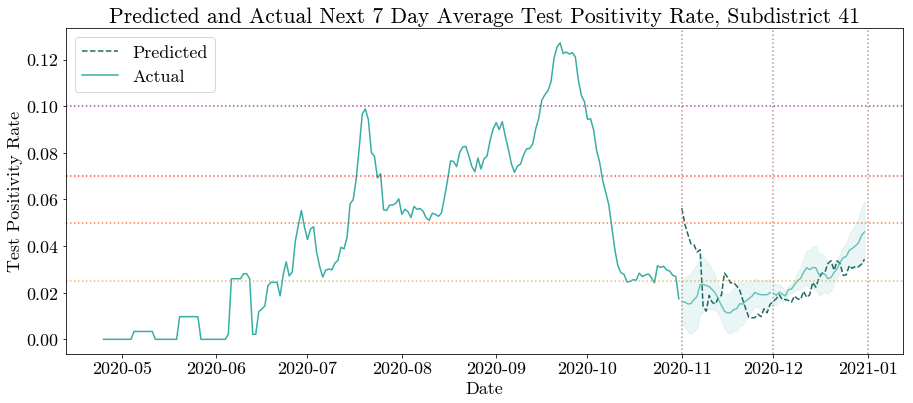

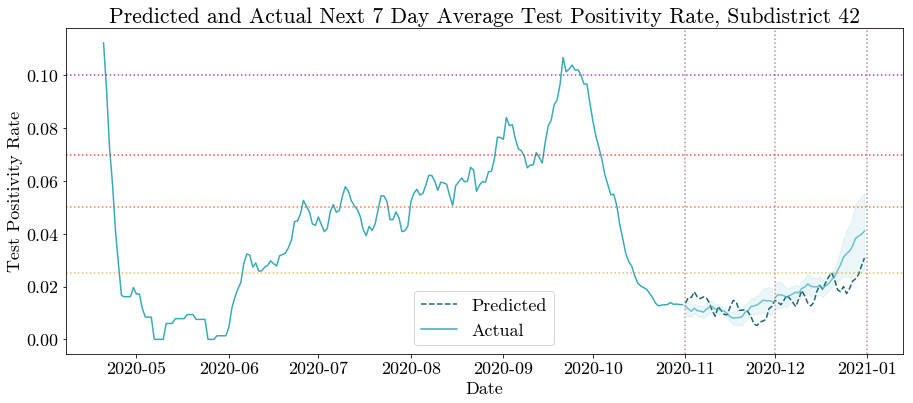

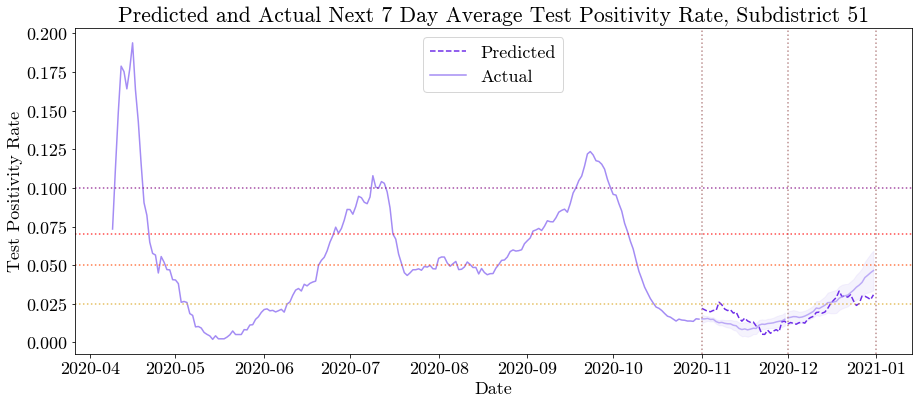

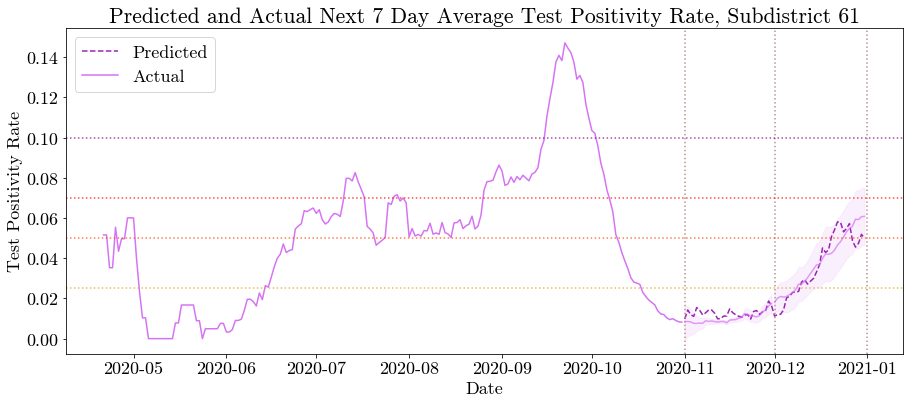

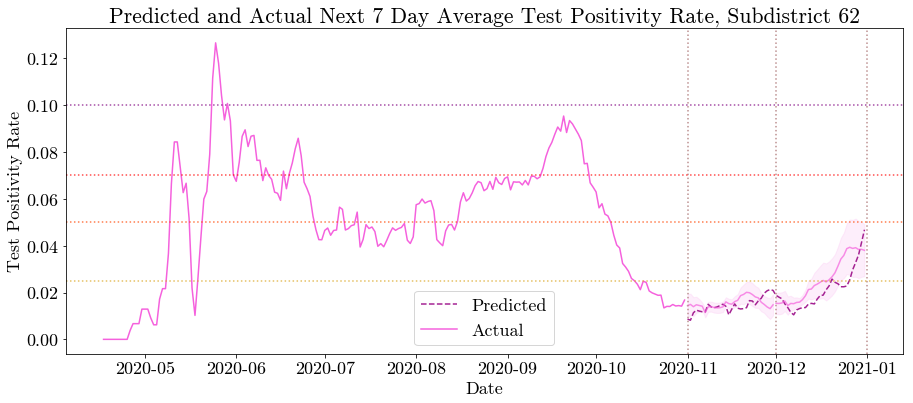

In [105]:
regions.sort()
for i in range(len(regions)):
     
    region = regions[i]
    color = colors[region]
    dark_color = dark_colors[region]
    
    od_df=df.where(df["Region"]==region).dropna()
    train = od_df.where(od_df["Date"] >= train_begin).where(od_df["Date"] <= '2020-10-31').dropna()
    test = od_df.where(od_df["Date"] >= '2020-11-01').where(od_df["Date"] <= '2020-11-30').dropna()
    dec = od_df.where(od_df["Date"] >= '2020-12-01').where(od_df["Date"] <= '2020-12-31').dropna()

    train_new = train.sort_index().dropna()
    test_new = test.sort_index().dropna()
    dec_new = dec.sort_index().dropna()
    y_train = train_new[label]
    y_test = test_new[label]
    y_dec = dec_new[label] 
    
    train_copy = train.copy()
    test_copy = test.copy()
    dec_copy = dec.copy()

    train_copy["actual"] = y_train
    train_copy["pred"] = y_train
    test_copy["actual"] = y_test
    test_copy["best_mse"] = osa_preds_list[0][32][region][:-7]
    dec_copy["actual"] = y_dec
    dec_copy["best_mse"] = dec_osa_preds_list[0][32][region][:-7]
    lower_bound_test = test_copy['95ci_lower']
    upper_bound_test = test_copy['95ci_upper']
    lower_bound_dec = dec_copy['95ci_lower']
    upper_bound_dec = dec_copy['95ci_upper']
        
    pred_all = pd.concat([train_copy, test_copy, dec_copy])
    fig, ax = plt.subplots(figsize=(15,6))

    # plot the final result on a sample dataset    
    toplot = pred_all
    toplot['Date'] = pd.to_datetime(toplot['Date'])
    test_copy['Date'] = pd.to_datetime(test_copy['Date'])
    plt.plot(toplot['Date'], toplot['best_mse'], color=dark_color, linestyle='--', label='Predicted')
    plt.fill_between(test_copy['Date'].values, y1=lower_bound_test, y2=upper_bound_test, color=color, alpha=.1)
    plt.fill_between(dec_copy['Date'].values, y1=lower_bound_dec, y2=upper_bound_dec, color=color, alpha=.1)
    plt.plot(train_copy['Date'], train_copy['actual'], color=color, label='Actual')
    plt.plot(test_copy['Date'], test_copy['actual'], color=color, label='_Hidden', alpha=0.7)
    plt.plot(dec_copy['Date'], dec_copy['actual'], color=color, label='_Hidden', alpha=0.7)
    #plt.plot(toplot['Date'], toplot[label_daily], color='lightsteelblue', label='daily %s' % (text_label))
    plt.axvline(x='2020-12-01', color='rosybrown', linestyle='dotted')
    plt.axvline(x='2020-11-01', color='rosybrown', linestyle='dotted')
    plt.axvline(x='2021-01-01', color='rosybrown', linestyle='dotted')
    plt.xlabel("Date")
    plt.ylabel("Test Positivity Rate")
    plt.title("Predicted and Actual Next 7 Day Average Test Positivity Rate, Subdistrict %d" % (region))
    plt.axhline(y=t5_prt, color='purple', linestyle='dotted', label='_Tier 5', alpha=0.7)
    plt.axhline(y=t4_prt, color='red', linestyle='dotted', label='_Tier 4', alpha=0.7)
    plt.axhline(y=t3_prt, color='orangered', linestyle='dotted', label='_Tier 3', alpha=0.7)
    plt.axhline(y=t2_prt, color='goldenrod', linestyle='dotted', label='_Tier 2', alpha=0.7)
    plt.legend(loc=0, ncol=1)
    plt.show()

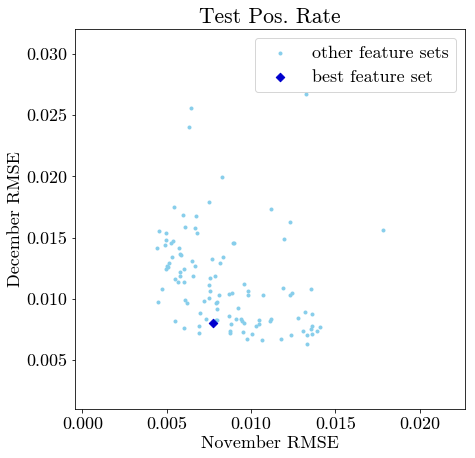

In [106]:
toplot_x = np.sqrt(results_to_consider["MSE Nov"])
toplot_y = np.sqrt(np.array(results_to_consider["MSE Dec"], dtype=np.float64))

change_font_size(18)
fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(toplot_x, toplot_y, label="other feature sets", marker='.', color='skyblue')
plt.scatter(np.sqrt(results_to_consider["MSE Nov"].iloc[31]), np.sqrt(results_to_consider["MSE Dec"].iloc[31]),
            color='mediumblue', label='best feature set', marker='D')
#plt.ylim((0, 800))
plt.title("Test Pos. Rate")
plt.xlabel("November RMSE")
plt.ylabel("December RMSE")
plt.legend()
plt.show()

# Dump Validation Set predictions to file

In [16]:
# dump experiments on exp decay results df and predictions
dump_to_pickle(all_results, '../OtherData/PRExpDecayTestSetResults_%s.pkl' % (file_suffix))
dump_to_pickle(dynamic_preds_list, '../OtherData/PRExpDecayTestSetDynamicPreds_%s.pkl' % (file_suffix))
dump_to_pickle(osa_preds_list, '../OtherData/PRExpDecayTestSetOSAPreds_%s.pkl' % (file_suffix))
dump_to_pickle(dec_osa_preds_list, '../OtherData/PRExpDecayTestSetOSAPredsDec_%s.pkl' % (file_suffix))

Saved file
Saved file
Saved file
Saved file


In [17]:
results_to_consider.to_csv("../OtherData/PRTestResults.csv")

In [107]:
cms = list()
cms_old = list()

cms_mob = list()

for region in regions:
     
    od_df=df.where(df["Region"]==region).dropna()
    train = od_df.where(od_df["Date"] >= train_begin).where(od_df["Date"] <= '2020-10-24').dropna()
    test = od_df.where(od_df["Date"] >= '2020-11-01').where(od_df["Date"] <= '2020-12-07').dropna()
    dec = od_df.where(od_df["Date"] >= '2020-12-01').where(od_df["Date"] <= '2021-01-07').dropna()

    train_new = train.sort_index().dropna()
    test_new = test.sort_index().dropna()
    dec_new = dec.sort_index().dropna()
    y_train = train_new[label]
    y_test = test_new[label]
    y_dec = dec_new[label] 
    
    train_copy = train.copy()
    test_copy = test.copy()
    dec_copy = dec.copy()

    train_copy["actual"] = y_train
    train_copy["pred"] = y_train
    test_copy["actual"] = y_test
    test_copy["best_mse"] = osa_preds_list[0][32][region]
    test_copy["mobility"] = osa_preds_list[0][8][region]
    dec_copy["actual"] = y_dec
    dec_copy["best_mse"] = dec_osa_preds_list[0][32][region]
    dec_copy["mobility"] = dec_osa_preds_list[0][8][region]
    
    
    cm = confusion_matrix_prt(test_copy["best_mse"], test_copy["actual"])
    cms.append(cm)
    cm = confusion_matrix_prt(dec_copy["best_mse"], dec_copy["actual"])
    cms.append(cm)
    cm = confusion_matrix_prt(test_copy["mobility"], test_copy["actual"])
    cms_mob.append(cm)
    cm = confusion_matrix_prt(dec_copy["mobility"], dec_copy["actual"])
    cms_mob.append(cm)
    cm = confusion_matrix_pr(test_copy["best_mse"], test_copy["actual"])
    cms_old.append(cm)
    cm = confusion_matrix_pr(dec_copy["best_mse"], dec_copy["actual"])
    cms_old.append(cm)

In [108]:
cmap = sns.diverging_palette(20, 210, s=95, l=60, as_cmap=True)

In [109]:
train_cm = sum(cms)
train_mob = sum(cms_mob)
train_cm_old = sum(cms_old)

In [110]:
train_cm.sum(axis=None)

427

In [111]:
train_cm_old.sum(axis=None)

427

In [112]:
train_cm

array([[235,  12,   1,   0,   0],
       [ 33,  96,   7,   0,   0],
       [  0,  18,  16,   0,   0],
       [  0,   0,   6,   3,   0],
       [  0,   0,   0,   0,   0]], dtype=int64)

In [113]:
train_cm_old = sum(cms_old)

In [114]:
train_cm_old

array([[178,  26,   1,   0],
       [ 43, 129,   7,   0],
       [  0,  18,  20,   0],
       [  0,   0,   5,   0]], dtype=int64)

In [115]:
train_cm.sum(axis=1) / train_cm.sum(axis=None)

array([0.58079625, 0.31850117, 0.07962529, 0.02107728, 0.        ])

In [116]:
train_cm_old.sum(axis=1) / train_cm_old.sum(axis=None)

array([0.48009368, 0.41920375, 0.08899297, 0.0117096 ])

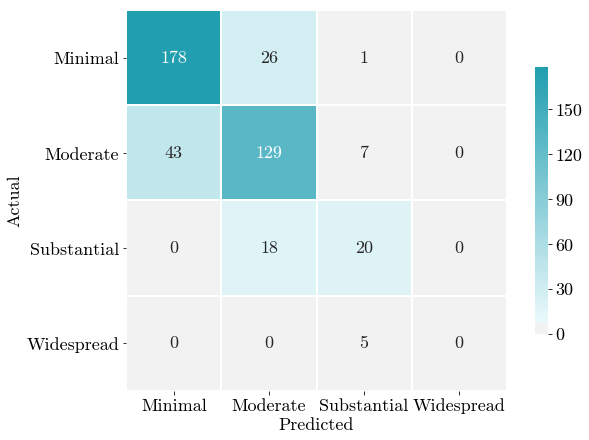

In [117]:
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(train_cm_old, index = ["Minimal", "Moderate", "Substantial", "Widespread"],
                  columns = ["Minimal", "Moderate", "Substantial", "Widespread"])
plt.figure(figsize = (10,7))
ax = plt.axes()
sns.heatmap(df_cm, annot=True, ax = ax, cmap=cmap, fmt='g',linewidths=1, square=True, center=0.5, cbar_kws={"shrink": .7})
#ax.set_title("Confusion Matrix of Magnitude Accuracy Predictions for PR (Test Regions only, Nov&Dec)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.yticks(rotation=0)
plt.show()

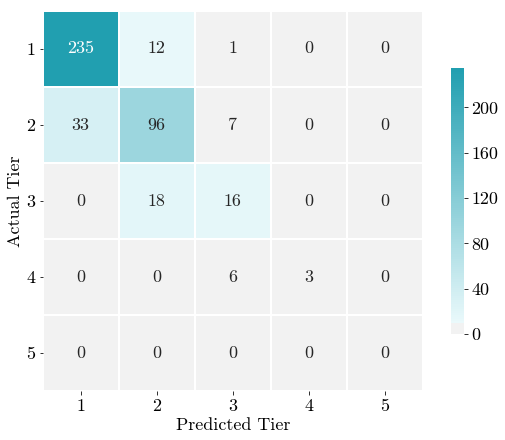

With mobility data


In [118]:


df_cm = pd.DataFrame(train_cm, index = ["1", "2", "3", "4", "5"],
                  columns = ["1", "2", "3", "4", "5"])
plt.figure(figsize = (10,7))
ax = plt.axes()
sns.heatmap(df_cm, annot=True, ax = ax, cmap=cmap, fmt='g',linewidths=1, square=True, center=0.5, cbar_kws={"shrink": .7})
#ax.set_title("Confusion Matrix of Magnitude Accuracy Predictions for PR(Test Regions only, Nov&Dec)")
ax.set_xlabel("Predicted Tier")
plt.yticks(rotation=0)
ax.set_ylabel("Actual Tier")
plt.show()
print("With mobility data")

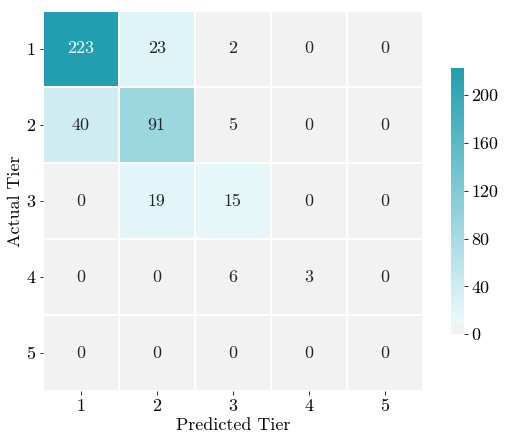

No mobility data


In [119]:


df_cm = pd.DataFrame(train_mob, index = ["1", "2", "3", "4", "5"],
                  columns = ["1", "2", "3", "4", "5"])
plt.figure(figsize = (10,7))
ax = plt.axes()
sns.heatmap(df_cm, annot=True, ax = ax, cmap=cmap, fmt='g',linewidths=1, square=True, center=0.5, cbar_kws={"shrink": .7})
#x.set_title("Confusion Matrix of Magnitude Accuracy Predictions for PR(Test Regions only, Nov&Dec)")
ax.set_xlabel("Predicted Tier")
plt.yticks(rotation=0)
ax.set_ylabel("Actual Tier")
plt.show()
print("No mobility data")

In [120]:
np.trace(train_cm) / np.sum(train_cm, axis=None)

0.819672131147541

In [121]:
np.trace(train_cm_old) / np.sum(train_cm_old, axis=None)

0.765807962529274

In [122]:
np.trace(train_cm_old)

327

In [123]:
ma_from_cm(train_cm)

0.819672131147541

In [124]:
ma_1tier_from_cm(train_cm)

0.9976580796252927

In [125]:
ma_from_cm(train_cm_old)

0.765807962529274

In [126]:
ma_1tier_from_cm(train_cm_old)

0.9976580796252927

In [127]:
ma_from_cm(train_mob)

0.7775175644028103

In [128]:
ma_1tier_from_cm(train_mob)

0.9953161592505855

In [130]:
colors

{11.0: [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 21.0: [0.9688417625390765, 0.46710871459052145, 0.1965441952393453],
 22.0: [0.8087954113106306, 0.5634700050056693, 0.19502642696727285],
 23.0: [0.7008633391290917, 0.6080365980075504, 0.19419512204856468],
 24.0: [0.5920891529639701, 0.6418467016378244, 0.1935069134991043],
 29.0: [0.4225883781014591, 0.677943504931845, 0.19271544738133076],
 31.0: [0.19783576093349015, 0.6955516966063037, 0.3995301037444499],
 32.0: [0.20518528131112984, 0.6851497738530601, 0.5562527763557912],
 41.0: [0.21044753832183283, 0.6773105080456748, 0.6433941168468681],
 42.0: [0.21576108198845112, 0.6690446872415565, 0.7201192992055431],
 43.0: [0.22335772267769388, 0.6565792317435265, 0.8171355503265633],
 44.0: [0.3531380715309417, 0.6201408220829481, 0.9586195235634788],
 51.0: [0.6423044349219739, 0.5497680051256467, 0.9582651433656727],
 61.0: [0.8397010947263905, 0.4529020995703274, 0.9578638063653008],
 62.0: [0.960388853994070